In [1]:
from keras import applications

model = applications.vgg16.VGG16(weights='imagenet')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [2]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = '/home/guhwanbae/workspace/machine-learning/resource/creative_commons/african_elephant.jpg'

input_shape = (224, 224)
img = image.load_img(img_path, target_size=input_shape)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Preprocess an input image according to VGG16 model.
# VGG16 model was trained with Caffe library.
# It converts RGB channels to BGR and subtract the mean of ImageNet dataset.
input_img = applications.vgg16.preprocess_input(img_tensor)

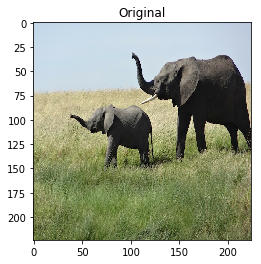

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


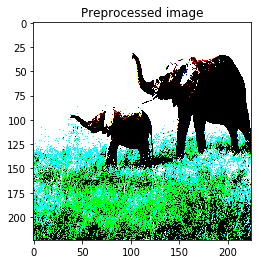

In [3]:
plt.figure('Original')
plt.title('Original')
plt.imshow(img)
plt.show()

plt.figure('Preprocessed image')
plt.title('Preprocessed image')
plt.imshow(input_img[0])
plt.show()

In [4]:
from keras import backend as K

def generate_heatmap(model, input_img, target_class_output, last_conv_layer):
    """ Return an activation heatmap, Grad-CAM. """
    # Gradients of target class about last_conv_layer output.
    # Shape of gradients is same as last_conv_layer output.
    grads = K.gradients(loss=target_class_output, variables=last_conv_layer.output)[0]
    # Feature elementwise mean.
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    iterate = K.function(inputs=[model.input],
                         outputs=[pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, last_conv_layer_output_value = iterate([input_img])
    # Multiply gradients to the last_conv_layer output.
    # Because output entries which effect dominantly to classify target class is significatnly changes.
    last_conv_layer_output_value[:,:] *= pooled_grads_value
    # Feature elementwise mean.
    heatmap = np.mean(last_conv_layer_output_value, axis=-1)
    # Normalize heatmap tensor.
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

Predicted:  [[('n02504458', 'African_elephant', 0.90942073), ('n01871265', 'tusker', 0.086183183), ('n02504013', 'Indian_elephant', 0.0043545808)]]


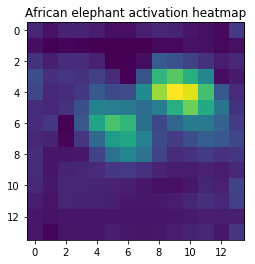

In [5]:
preds = model.predict(input_img)
print('Predicted: ', applications.vgg16.decode_predictions(preds, top=3))

idx = np.argmax(preds)
african_elephant_output = model.output[:idx]
last_conv_layer = model.get_layer('block5_conv3')

african_elephant_heatmap = generate_heatmap(model,
                                            input_img=input_img,
                                            target_class_output=african_elephant_output,
                                            last_conv_layer=last_conv_layer)

plt.figure('African elephant activation heatmap')
plt.title('African elephant activation heatmap')
plt.imshow(african_elephant_heatmap, cmap='viridis')

In [6]:
import cv2, os

def overlap(heatmap, src_image_path):
    """ Overlap orginal image and activation heatmap. """
    src = cv2.imread(src_image_path)
    (height, width, n_channels) = src.shape
    heatmap = cv2.resize(heatmap.copy(), (width, height))
    heatmap = (heatmap * 255).astype('uint8')
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlapped = src + (heatmap * 0.4)
    # Save a overlapped image.
    dst_image_path = os.path.join(os.getcwd(), 'heatmap_overlapped.jpg')
    cv2.imwrite(dst_image_path, overlapped)
    return cv2.imread(dst_image_path)

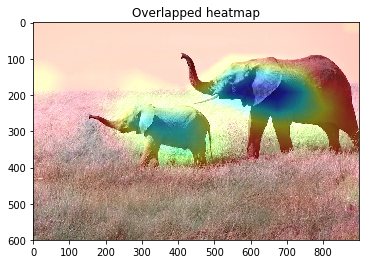

In [7]:
overlapped = overlap(african_elephant_heatmap, img_path)

plt.figure('Overlapped heatmap')
plt.title('Overlapped heatmap')
plt.imshow(overlapped)
plt.show()

'''
The ear of mother elephant is highly activated.
In fact, an african elephant has a bigger ear than an indian.
VGG16 network maybe learned this difference.
'''